# **Survival Convolutional Neural Network** (from 2D CT scans)

In [ ]:
import tensorflow as tf 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from typing import Dict, Iterable, Sequence, Tuple, Optional
import pathlib
from pathlib import Path
pip install lifelines
from lifelines.utils import concordance_index

## **Loading Data and Preprocessing**

### **Loading of CT scans**

In [ ]:
train_folder = pathlib.Path("/content/drive/My Drive/x_train/images")
all_image_paths = [str(img_path) for img_path in list(train_folder.glob("*"))]
all_image_paths = sorted(all_image_paths)

CT scans store raw voxel intensity in Hounsfield units (HU). This is defined as Air = −1000 HU, Lung ≈ −500 HU, Water = 0 HU, Soft tissue (& blood) ≈ +50 HU, Bone ≈ +1000 HU. A lung window from -1200 to +800 can be applied to view lung tumor and normalize CT scans.

For each CT scan, there is a segmentation mask of the same size, composed of zeros everywhere there is no tumour, and 1 otherwise.

My objective being to increase the size of the training data by cutting each 3D CT scan at the center of the tumor on each axis, I used this mask to identify the position of the tumor on the CT scan.

In [ ]:
def read_file(filepath):
    # Read file
    scan = np.load(filepath)
    # Get raw data
    scan = scan['scan']
    return scan

def normalize(volume):
    min = -1200
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def process_scan(path):
    # Read scan
    volume = read_file(path)
    # Normalize and use of the segmentation mask 
    scan = np.load(path)
    volume = normalize(volume)*scan['mask']
    return volume

In [ ]:
# Each scan is rescaled.
normal_scans = np.array([process_scan(path) for path in all_image_paths])
normal_scans.shape

### **Creation of 2D CT scans**

I noticed that 6 of the 300 training CT scans don't have any delimited tumor (the segmentation mask is composed of zeros only). These CT scans are not used in the creations of the 2D CT scans.

In [ ]:
def two_d(scan):
  liste=[]
  for i in range(0,300):
    # Removal of the CT scans without delimited tumor
    if i !=1 and i!=177 and i!=183 and i!=229 and i!=277 and i!=290:
      a=np.where(scan[i]>0)
      median_ax0=int(np.median(a[0]))
      median_ax1=int(np.median(a[1]))
      median_ax2=int(np.median(a[2]))
      image_1=scan[i][median_ax0,:,:]
      image_2=scan[i][:,median_ax1,:]
      image_3=scan[i][:,:,median_ax2]
      liste.append(image_1)
      liste.append(image_2)
      liste.append(image_3)
      scans=(np.array(liste))
  return scans

In [ ]:
scan_2d=two_d(normal_scans)
scan_2d.shape

### **Vizualization of a 2D CT scan**

[]

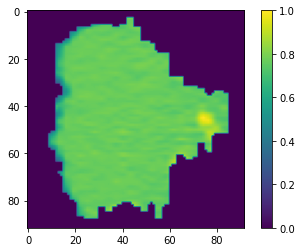

In [ ]:
plt.imshow(scan_2d[0])
plt.colorbar()
plt.plot()

We can see that where no tumor has been identified, the value is equal to zero.

### **Target and Censorship Variables**

In [ ]:
y_train = pd.read_csv( '/content/drive/My Drive/Owkin project/y_train.csv', index_col=0)
y_train=y_train.sort_index()

# Removal of the 6 patients who do not have a delimited tumor on the CT scan
y_train=y_train.drop(index=[3,256,263,327,391,409])

# Survival time and event are duplicated, patients having three 2D CT scans
survivaltime=[x for x in (y_train.SurvivalTime)]
event=[x for x in (y_train.Event)]

survivaltime=pd.Series(survivaltime)
survivaltime=survivaltime.repeat(3)
event=pd.Series(event)
event=event.repeat(3)

### **Splitting Train Data in Training and Validation**

In [ ]:
# Split data in the ratio 70-30 for training and validation.
x_train = scan_2d[:780]
time_train = np.array(survivaltime[:780])
event_train = np.array(event[:780])

x_test = scan_2d[780:]
time_test = np.array(survivaltime[780:])
event_test = np.array(event[780:])

## **Creation of Convolution Neural Network for Survival Analysis**

### **Train and Validation Data**

In [ ]:
def _make_riskset(time: np.ndarray) -> np.ndarray:
    """Compute mask that represents each sample's risk set.

    Parameters
    ----------
    time : np.ndarray, shape=(n_samples,)
        Observed event time sorted in descending order.

    Returns
    -------
    risk_set : np.ndarray, shape=(n_samples, n_samples)
        Boolean matrix where the `i`-th row denotes the
        risk set of the `i`-th instance, i.e. the indices `j`
        for which the observer time `y_j >= y_i`.
    """
    assert time.ndim == 1, "expected 1D array"

    # sort in descending order
    o = np.argsort(-time, kind="mergesort")
    n_samples = len(time)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    for i_org, i_sort in enumerate(o):
        ti = time[i_sort]
        k = i_org
        while k < n_samples and ti == time[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set


class InputFunction:
    """Callable input function that computes the risk set for each batch.
    
    Parameters
    ----------
    images : np.ndarray, shape=(n_samples, height, width)
        Image data.
    time : np.ndarray, shape=(n_samples,)
        Observed time.
    event : np.ndarray, shape=(n_samples,)
        Event indicator.
    batch_size : int, optional, default=64
        Number of samples per batch.
    drop_last : int, optional, default=False
        Whether to drop the last incomplete batch.
    shuffle : bool, optional, default=False
        Whether to shuffle data.
    seed : int, optional, default=89
        Random number seed.
    """

    def __init__(self,
                 images: np.ndarray,
                 time: np.ndarray,
                 event: np.ndarray,
                 batch_size: int = 20,
                 drop_last: bool = False,
                 shuffle: bool = False,
                 seed: int = 89) -> None:
        if images.ndim == 3:
            images = images[..., np.newaxis]
        self.images = images
        self.time = time
        self.event = event
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.shuffle = shuffle
        self.seed = seed

    def size(self) -> int:
        """Total number of samples."""
        return self.images.shape[0]

    def steps_per_epoch(self) -> int:
        """Number of batches for one epoch."""
        return int(np.floor(self.size() / self.batch_size))

    def _get_data_batch(self, index: np.ndarray) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        """Compute risk set for samples in batch."""
        time = self.time[index]
        event = self.event[index]
        images = self.images[index]

        labels = {
            "label_event": event.astype(np.int32),
            "label_time": time.astype(np.float32),
            "label_riskset": _make_riskset(time)
        }
        return images, labels

    def _iter_data(self) -> Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
        """Generator that yields one batch at a time."""
        index = np.arange(self.size())
        rnd = np.random.RandomState(self.seed)

        if self.shuffle:
            rnd.shuffle(index)
        for b in range(self.steps_per_epoch()):
            start = b * self.batch_size
            idx = index[start:(start + self.batch_size)]
            yield self._get_data_batch(idx)

        if not self.drop_last:
            start = self.steps_per_epoch() * self.batch_size
            idx = index[start:]
            yield self._get_data_batch(idx)

    def _get_shapes(self) -> Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
        """Return shapes of data returned by `self._iter_data`."""
        batch_size = self.batch_size if self.drop_last else None
        h, w, c = self.images.shape[1:]
        images = tf.TensorShape([batch_size, h, w, c])

        labels = {k: tf.TensorShape((batch_size,))
                  for k in ("label_event", "label_time")}
        labels["label_riskset"] = tf.TensorShape((batch_size, batch_size))
        return images, labels

    def _get_dtypes(self) -> Tuple[tf.DType, Dict[str, tf.DType]]:
        """Return dtypes of data returned by `self._iter_data`."""
        labels = {"label_event": tf.int32,
                  "label_time": tf.float32,
                  "label_riskset": tf.bool}
        return tf.float32, labels

    def _make_dataset(self) -> tf.data.Dataset:
        """Create dataset from generator."""
        ds = tf.data.Dataset.from_generator(
            self._iter_data,
            self._get_dtypes(),
            self._get_shapes()
        )
        return ds

    def __call__(self) -> tf.data.Dataset:
        return self._make_dataset()


def safe_normalize(x: tf.Tensor) -> tf.Tensor:
    """Normalize risk scores to avoid exp underflowing.

    Note that only risk scores relative to each other matter.
    If minimum risk score is negative, we shift scores so minimum
    is at zero.
    """
    x_min = tf.reduce_min(x, axis=0)
    c = tf.zeros_like(x_min)
    norm = tf.where(x_min < 0, -x_min, c)
    return x + norm


def logsumexp_masked(risk_scores: tf.Tensor,
                     mask: tf.Tensor,
                     axis: int = 0,
                     keepdims: Optional[bool] = None) -> tf.Tensor:
    """Compute logsumexp across `axis` for entries where `mask` is true."""
    risk_scores.shape.assert_same_rank(mask.shape)

    with tf.name_scope("logsumexp_masked"):
        mask_f = tf.cast(mask, risk_scores.dtype)
        risk_scores_masked = tf.math.multiply(risk_scores, mask_f)
        # for numerical stability, substract the maximum value
        # before taking the exponential
        amax = tf.reduce_max(risk_scores_masked, axis=axis, keepdims=True)
        risk_scores_shift = risk_scores_masked - amax

        exp_masked = tf.math.multiply(tf.exp(risk_scores_shift), mask_f)
        exp_sum = tf.reduce_sum(exp_masked, axis=axis, keepdims=True)
        output = amax + tf.math.log(exp_sum)
        if not keepdims:
            output = tf.squeeze(output, axis=axis)
    return output

### **Computation of Cox PH loss function**

In [ ]:
class CoxPHLoss(tf.keras.losses.Loss):
    """Negative partial log-likelihood of Cox's proportional hazards model."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)            

    def call(self,
             y_true: Sequence[tf.Tensor],
             y_pred: tf.Tensor) -> tf.Tensor:
        """Compute loss.

        Parameters
        ----------
        y_true : list|tuple of tf.Tensor
            The first element holds a binary vector where 1
            indicates an event 0 censoring.
            The second element holds the riskset, a
            boolean matrix where the `i`-th row denotes the
            risk set of the `i`-th instance, i.e. the indices `j`
            for which the observer time `y_j >= y_i`.
            Both must be rank 2 tensors.
        y_pred : tf.Tensor
            The predicted outputs. Must be a rank 2 tensor.

        Returns
        -------
        loss : tf.Tensor
            Loss for each instance in the batch.
        """
        event, riskset = y_true
        predictions = y_pred

        pred_shape = predictions.shape
        if pred_shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "be 2." % pred_shape.ndims)

        if pred_shape[1] is None:
            raise ValueError("Last dimension of predictions must be known.")

        if pred_shape[1] != 1:
            raise ValueError("Dimension mismatch: Last dimension of predictions "
                             "(received %s) must be 1." % pred_shape[1])

        if event.shape.ndims != pred_shape.ndims:
            raise ValueError("Rank mismatch: Rank of predictions (received %s) should "
                             "equal rank of event (received %s)" % (
                pred_shape.ndims, event.shape.ndims))

        if riskset.shape.ndims != 2:
            raise ValueError("Rank mismatch: Rank of riskset (received %s) should "
                             "be 2." % riskset.shape.ndims)

        event = tf.cast(event, predictions.dtype)
        predictions = safe_normalize(predictions)

        with tf.name_scope("assertions"):
            assertions = (
                tf.debugging.assert_less_equal(event, 1.),
                tf.debugging.assert_greater_equal(event, 0.),
                tf.debugging.assert_type(riskset, tf.bool)
            )

        # move batch dimension to the end so predictions get broadcast
        # row-wise when multiplying by riskset
        pred_t = tf.transpose(predictions)
        # compute log of sum over risk set for each row
        rr = logsumexp_masked(pred_t, riskset, axis=1, keepdims=True)
        assert rr.shape.as_list() == predictions.shape.as_list()

        losses = tf.math.multiply(event, rr - predictions)

        return losses

### **Computation of the Concordance Index** (on the validation data at each epoch)

In [ ]:
class CindexMetric:
    """Computes concordance index across one epoch."""

    def reset_states(self) -> None:
        """Clear the buffer of collected values."""
        self._data = {
            "label_time": [],
            "label_event": [],
            "prediction": []
        }

    def update_state(self, y_true: Dict[str, tf.Tensor], y_pred: tf.Tensor) -> None:
        """Collect observed time, event indicator and predictions for a batch.

        Parameters
        ----------
        y_true : dict
            Must have two items:
            `label_time`, a tensor containing observed time for one batch,
            and `label_event`, a tensor containing event indicator for one batch.
        y_pred : tf.Tensor
            Tensor containing predicted risk score for one batch.
        """
        self._data["label_time"].append(y_true["label_time"].numpy())
        self._data["label_event"].append(y_true["label_event"].numpy())
        self._data["prediction"].append(tf.squeeze(y_pred).numpy())

    def result(self) -> Dict[str, float]:
        """Computes the concordance index across collected values.

        Returns
        ----------
        metrics : dict
            Computed metrics.
        """
        data = {}
        for k, v in self._data.items():
            data[k] = np.concatenate(v)

        results = concordance_index(
            data["label_time"],
            data["prediction"],
            data["label_event"] == 1,)

        result_data = {}
        names = "cindex"
        result_data[names] = 1-results

        return result_data

### **Training of Survival Convolutional Neural Network**

In [ ]:
import tensorflow.compat.v2.summary as summary
from tensorflow.python.ops import summary_ops_v2


class TrainAndEvaluateModel:

    def __init__(self, model, model_dir, train_dataset, eval_dataset,
                 learning_rate, num_epochs):
        self.num_epochs = num_epochs
        self.model_dir = model_dir

        self.model = model

        self.train_ds = train_dataset

        self.val_ds = eval_dataset

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.loss_fn = CoxPHLoss()

        self.train_loss_metric = tf.keras.metrics.Mean(name="train_loss")
        self.val_loss_metric = tf.keras.metrics.Mean(name="val_loss")
        self.val_cindex_metric = CindexMetric()

    @tf.function
    def train_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)

            train_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=logits)

        with tf.name_scope("gradients"):
            grads = tape.gradient(train_loss, self.model.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        return train_loss, logits

    def train_and_evaluate(self):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=self.optimizer,
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        train_summary_writer = summary.create_file_writer(
            str(self.model_dir / "train"))
        val_summary_writer = summary.create_file_writer(
            str(self.model_dir / "valid"))

        for epoch in range(self.num_epochs):
            with train_summary_writer.as_default():
                self.train_one_epoch(ckpt.step)

            # Run a validation loop at the end of each epoch.
            with val_summary_writer.as_default():
                self.evaluate(ckpt.step)

        save_path = ckpt_manager.save()
        print(f"Saved checkpoint for step {ckpt.step.numpy()}: {save_path}")

    def train_one_epoch(self, step_counter):
        for x, y in self.train_ds:
            x = tf.image.random_brightness(x,0.2)
            #x = tf.image.random_contrast(x, 0.2, 0.5)
            train_loss, logits = self.train_one_step(
                x, y["label_event"], y["label_riskset"])

            step = int(step_counter)

            # Update training metric.
            self.train_loss_metric.update_state(train_loss)

            # Log every 200 batches.
            if step % 5 == 0:
                # Display metrics
                mean_loss = self.train_loss_metric.result()
                print(f"step {step}: mean loss = {mean_loss:.4f}")
                # save summaries
                summary.scalar("loss", mean_loss, step=step_counter)
                # Reset training metrics
                self.train_loss_metric.reset_states()

            step_counter.assign_add(1)

    @tf.function
    def evaluate_one_step(self, x, y_event, y_riskset):
        y_event = tf.expand_dims(y_event, axis=1)
        val_logits = self.model(x, training=False)
        val_loss = self.loss_fn(y_true=[y_event, y_riskset], y_pred=val_logits)
        return val_loss, val_logits

    def evaluate(self, step_counter):
        self.val_cindex_metric.reset_states()
        
        for x_val, y_val in self.val_ds:
            val_loss, val_logits = self.evaluate_one_step(
                x_val, y_val["label_event"], y_val["label_riskset"])

            # Update val metrics
            self.val_loss_metric.update_state(val_loss)
            self.val_cindex_metric.update_state(y_val, val_logits)

        val_loss = self.val_loss_metric.result()
        summary.scalar("loss",
                       val_loss,
                       step=step_counter)
        self.val_loss_metric.reset_states()
        
        val_cindex = self.val_cindex_metric.result()
        for key, value in val_cindex.items():
          summary.scalar(key, value, step=step_counter)

        print(f"Validation: loss = {val_loss:.4f}, cindex = {val_cindex['cindex']:.4f}")

### **Architecture of the Survival Convolutional Neural Network**

The architecture of the CNN is similar to the one using 3D CT scan, but adapted to 2D images.

- The size of the CT scans (grayscale image) is 92x92. They are normalized by batch before being fed to the network.
- Two convolutional layers using a 3x3 kernel size, stride 1, padding='valid', and a ReLu activation function, followed by a batch normalization and a max pooling layer with a pool size of 2, dividing the spatial dimension with a size of 2.
- Fully connected network, composed of two hidden dense layers and a dense output layer. A batch normalization is applied on the output of the two hidden dense layers. The final dense layer output the predictions (risk score). A dropout layer with a dropout rate of 20% is added to reduce overfitting.

*Note: the CNN using the 2D CT scans tend to overfit more quickly than the CNN using 3D CT scans.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = tf.keras.Sequential([
                             
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(120, name='dense_1', activation="relu", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(84, name='dense_2', activation="relu", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.20),
    
    tf.keras.layers.Dense(1, activation='linear', name='dense_3')
])

*Note: below some of the changes I tried to improve the results

- Additional CONV2D and Dense layers
- Additional filters in the CONV2D layers
- Batch normalization layers before the activation function
- Different regularization techniques to reduce the overfitting:
    - Dropout at higher rates
    - Dropout layers before every CONV2D layers
    - L1/L2 regularization

I did not get better results than with the CNN using 3D CT scans.

In [ ]:
train_fn = InputFunction(x_train, time_train, event_train, batch_size=20, shuffle=True, drop_last=True)

eval_fn = InputFunction(x_test, time_test, event_test)

trainer = TrainAndEvaluateModel(
    model=model,
    model_dir=Path("ckpts-mnist-cnn"),
    train_dataset=train_fn(),
    eval_dataset=eval_fn(),
    learning_rate=0.01,
    num_epochs=20,
)

In [ ]:
trainer.train_and_evaluate()

## **Results**

### **Predicted Risk Score**

In [ ]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(alpha=0.05)

class Predictor:

    def __init__(self, model, model_dir):
        self.model = model
        self.model_dir = model_dir

    def predict(self, dataset):
        ckpt = tf.train.Checkpoint(
            step=tf.Variable(0, dtype=tf.int64),
            optimizer=tf.keras.optimizers.Adam(),
            model=self.model)
        ckpt_manager = tf.train.CheckpointManager(
            ckpt, str(self.model_dir), max_to_keep=2)

        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
            print(f"Latest checkpoint restored from {ckpt_manager.latest_checkpoint}.")

        risk_scores = []
        for batch in dataset:
            pred = self.model(batch, training=False)
            risk_scores.append(pred.numpy())

        return np.row_stack(risk_scores)

**On Train Data**

In [ ]:
train_pred_fn = tf.data.Dataset.from_tensor_slices(x_train[..., np.newaxis]).batch(20)

predictor = Predictor(model, trainer.model_dir)

In [ ]:
# Predicted risk score of train data
train_predictions = predictor.predict(train_pred_fn)

risk_score_train=pd.DataFrame(train_predictions)
risk_score_train['time_train']=time_train
risk_score_train['event_train']=event_train
risk_score_train=risk_score_train.rename(columns={0:'risk_score'})
risk_score_train.head()

**On Validation Data**

In [ ]:
#Predicted risk score of validation data
sample_pred_ds = tf.data.Dataset.from_tensor_slices(x_test[..., np.newaxis]).batch(20)
sample_predictions = predictor.predict(sample_pred_ds)

risk_score_val=pd.DataFrame(sample_predictions)
risk_score_val['time_test']=time_test
risk_score_val['event_test']=event_test
risk_score_val=risk_score_val.rename(columns={0:'risk_score'})
risk_score_val.head()